# Cryptocurrency Price Forecasting

In [2]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
import scipy.special as sc
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('all_currencies.csv',parse_dates=['Date'], index_col='Date',
               date_parser=dateparse)
df=pd.read_csv('all_currencies.csv')
df= df.assign(Date = pd.to_datetime(df['Date']))
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [4]:
df.tail()

,Date,Symbol,Open,High,Low,Close,Volume,Market Cap
632213,2018-09-23,ZZC,0.067149,0.067324,0.024069,0.024161,34.0,130705.0
632214,2018-09-24,ZZC,0.024167,0.091875,0.024121,0.091631,58.0,47041.0
632215,2018-09-25,ZZC,0.091528,0.091568,0.057507,0.090547,752.0,178158.0
632216,2018-09-26,ZZC,0.090400,0.104745,0.086071,0.086559,60.0,175963.0
632217,2018-09-27,ZZC,0.086664,0.130541,0.067363,0.073475,91.0,168691.0


In [5]:
df.dtypes

Date          datetime64[ns]
Symbol                object
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume               float64
Market Cap           float64
dtype: object

# Bitcoin

In [6]:
df_btc = df[df['Symbol']=='BTC']

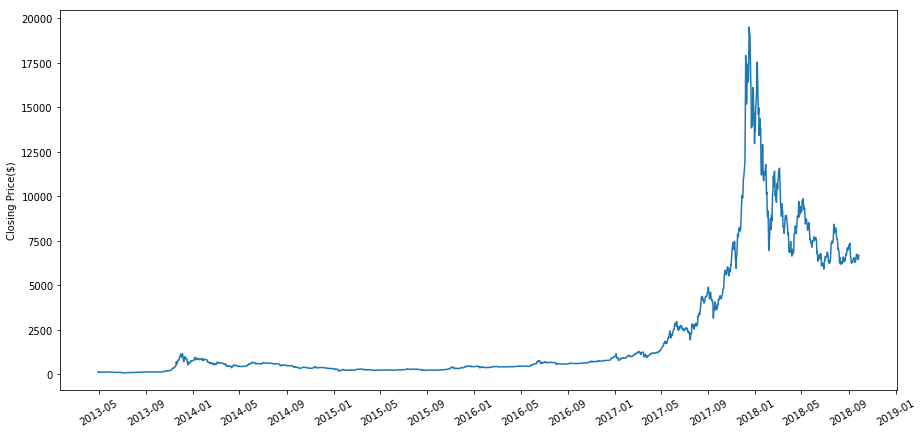

In [7]:
fig, ax = plt.subplots(figsize=(15,7))

plt.plot(df_btc['Date'],df_btc['Close'])
plt.ylabel('Closing Price($)')
majorFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,5,9]))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
plt.show()


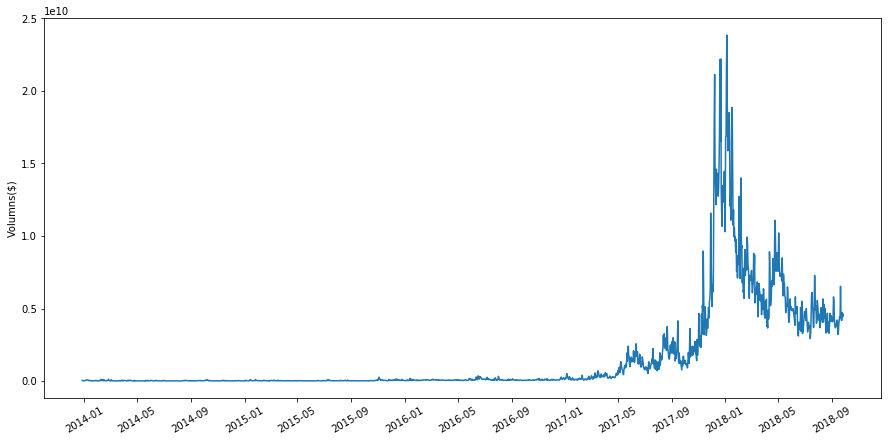

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(df_btc['Date'], df_btc['Volume'])
plt.ylabel('Volumns($)')
majorFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,5,9]))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)

plt.show()

# AR, MA & ARMA

In [9]:
#import package for ARIMA 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/cyian/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Check stationarity 

A stationary time seires is one whose mean is constant over time and covaraince  cov($X_t,X_{t+h})$ does not depend on t.

We need to make sure that the time series data is stationary to use the ARMA model.

In [10]:
df_btc = df_btc.set_index('Date')

In [11]:
df_btc.head()

,Symbol,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2013-04-28,BTC,135.30,135.98,132.10,134.21,NaN,1.500520e+09
2013-04-29,BTC,134.44,147.49,134.00,144.54,NaN,1.491160e+09
2013-04-30,BTC,144.00,146.93,134.05,139.00,NaN,1.597780e+09
2013-05-01,BTC,139.00,139.89,107.72,116.99,NaN,1.542820e+09
2013-05-02,BTC,116.38,125.60,92.28,105.21,NaN,1.292190e+09


In [12]:
print('First day record : {}'.format(df_btc.index[0]))
print('Last day record: {}'.format(df_btc.index[-1]))

First day record : 2013-04-28 00:00:00
Last day record: 2018-09-27 00:00:00


In [13]:
# Resampling to monthly frequency
btc_month = df_btc.resample('M').mean()

In [14]:
btc_month.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-30,137.913333,143.466667,133.383333,139.250000,NaN,1.529820e+09
2013-05-31,120.292258,123.948710,114.253226,119.992581,NaN,1.342523e+09
2013-06-30,108.856667,111.300667,104.602000,107.761333,NaN,1.228664e+09
2013-07-31,90.311290,93.869032,86.719677,90.512258,NaN,1.031498e+09
2013-08-31,113.041935,116.002258,111.387742,113.905161,NaN,1.306910e+09


By Wikipedia: In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

In [15]:
series = btc_month.Close
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.147333
p-value: 0.695832
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591


The null hypothesis in the test is: this series of data is non-stationary. \\
And the statistic value is greater than the all the critical values that are listed, which means that the null hypothesis cannot be rejected by these confidence levels. We should consider this series is not stationary. 

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

Dickey–Fuller test: p=0.695832


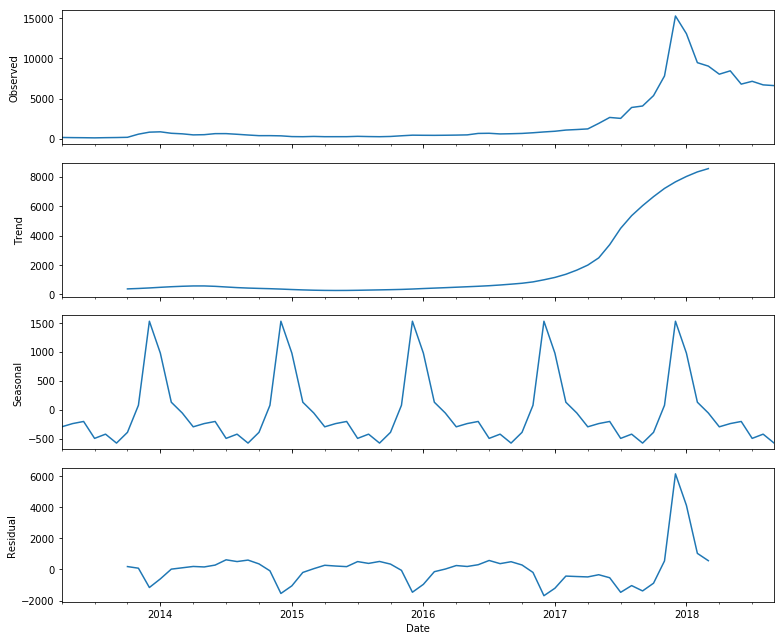

In [17]:
seasonal_decompose(btc_month.Close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])
plt.show()

The p-value indicates that series is not stationary with 69.58% confidence

We observed that the bitcoin price is somewhat stable before 2017, but experienced an amazing growth in the end of 2017, and then crashed a certain amount in 2018.

However the residual in the plot has a very obvious seasonal trend. This data need some transformation.

In [18]:
def init_boxcox(data):
    from scipy.special import inv_boxcox as inverse
    from scipy.stats import boxcox as forward
    lambdas = dict()

    def myforward(data):
        transformed, lambdas[data.name] = forward(1 + data)
        if lambdas[data.name]<0:
            lambdas[data.name]=0
        transformed=np.log1p(data)
        return transformed

    def myinverse(data):
        if lambdas[data.name]==0:
            return np.expm1(data)
        else:
            transformed = inverse(data, lambdas[data.name])-1
        return transformed

    return myforward(data), myinverse(data)

In [19]:
from scipy.special import boxcox1p

In [20]:
lmd_values = [0.1, 0.25, 0.5, 1, 2, 3, 3.2, 3.5]
for lmd in lmd_values:
    boxcox_x = boxcox1p(btc_month.Close, lmd)
    print("Dickey–Fuller test: p=%f" % adfuller(boxcox_x)[1])

Dickey–Fuller test: p=0.807421
Dickey–Fuller test: p=0.845444
Dickey–Fuller test: p=0.825181
Dickey–Fuller test: p=0.695832
Dickey–Fuller test: p=0.083645
Dickey–Fuller test: p=0.003461
Dickey–Fuller test: p=0.001849
Dickey–Fuller test: p=1.000000


We can see with the lambda value as 3.2, the p value indicates that the process becomes more stationary than the original one. 

Dickey–Fuller test: p=0.793401


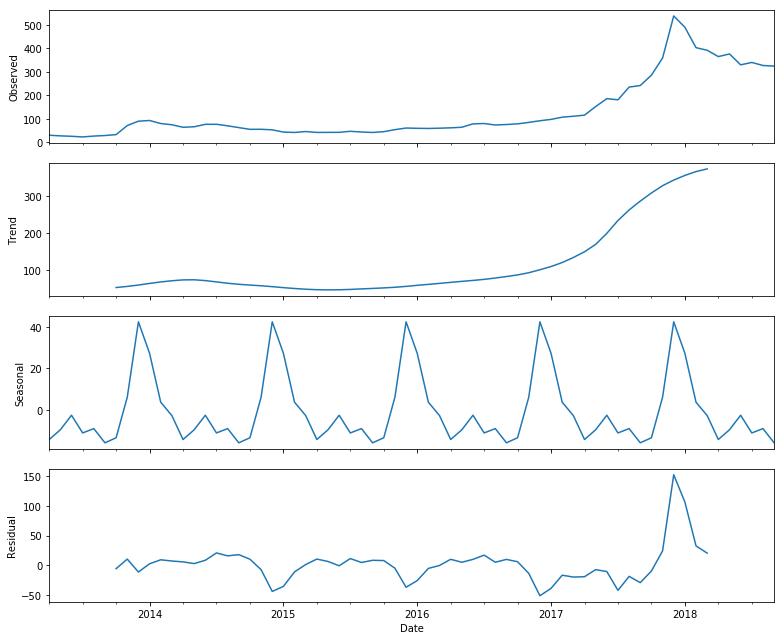

In [21]:
lmbda = 0.6
btc_month['box_cox'] = boxcox1p(btc_month.Close, lmbda)
seasonal_decompose(btc_month.box_cox).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_cox)[1])
plt.show()

## Differencing

We need to use differencing method to make the series data stationary.


In [22]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.box_cox - btc_month.box_cox.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.940636


In [23]:
# Seasonal differentiation (6 months)
btc_month['box_diff_seasonal_6'] = btc_month.box_cox - btc_month.box_cox.shift(6)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_6[6:])[1])

Dickey–Fuller test: p=0.599853


In [24]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.box_cox - btc_month.box_cox.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.014911


In [25]:
# Seasonal differentiation (1 months)
btc_month['box_diff_seasonal_1'] = btc_month.box_cox - btc_month.box_cox.shift(1)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_1[1:])[1])

Dickey–Fuller test: p=0.000000


### Regular differentiation
sometimes it makes sense that some of the seasonality needs to be catched by the second order differencing. 

Dickey–Fuller test: p=0.004854


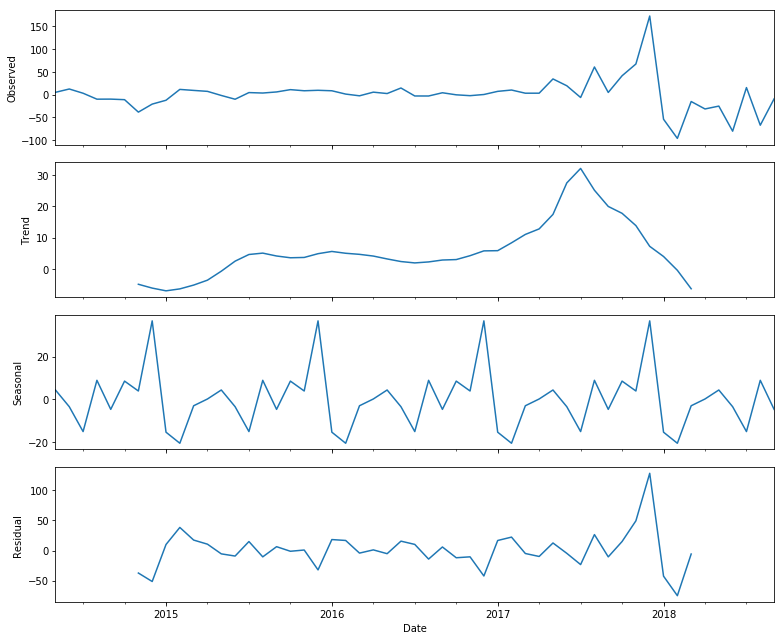

In [26]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])
plt.show()

This result indicates that the second order of differencing works better than the original one in terms of the staionary. And the residual plot has less pattern than before. 

## ACF - 12 months first order

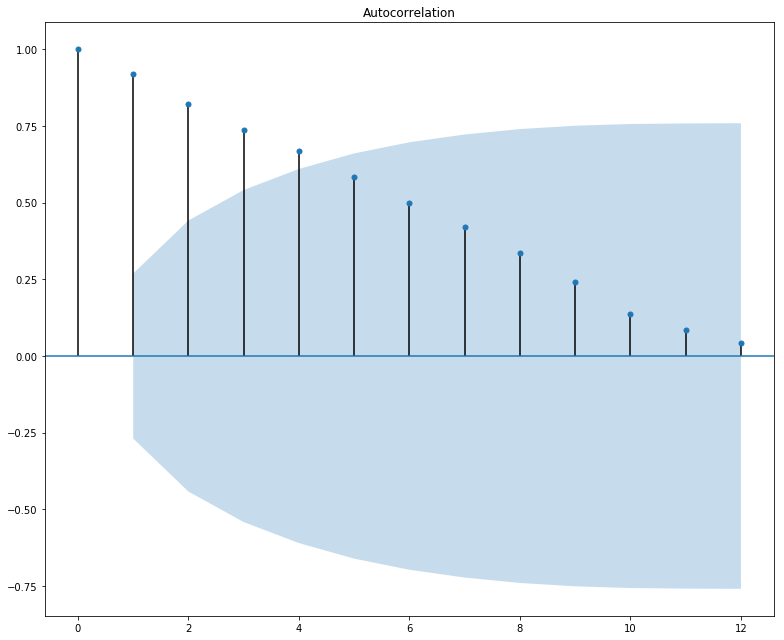

In [27]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)
plt.tight_layout()
plt.show()

The autocorrlation plot shown above demonstrates the probability of existing correlation outside this 95 confidence interval cone. The first 4 lags are significant. We could consider MA(4) as the starting model.

## PACF

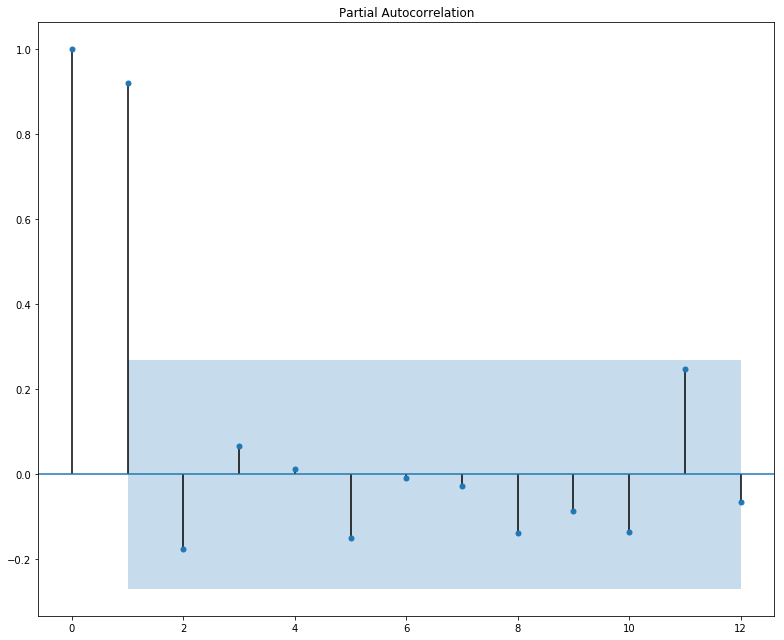

In [28]:
plot_pacf(btc_month.Close[13:].values.squeeze(), lags=12)
plt.tight_layout()
plt.show()

The partial autocorrelation plot displays no spikes outside the significance interval, which means that there probably no enough information to be drawn by the autoregression model. 

## ACF - 12 months second order

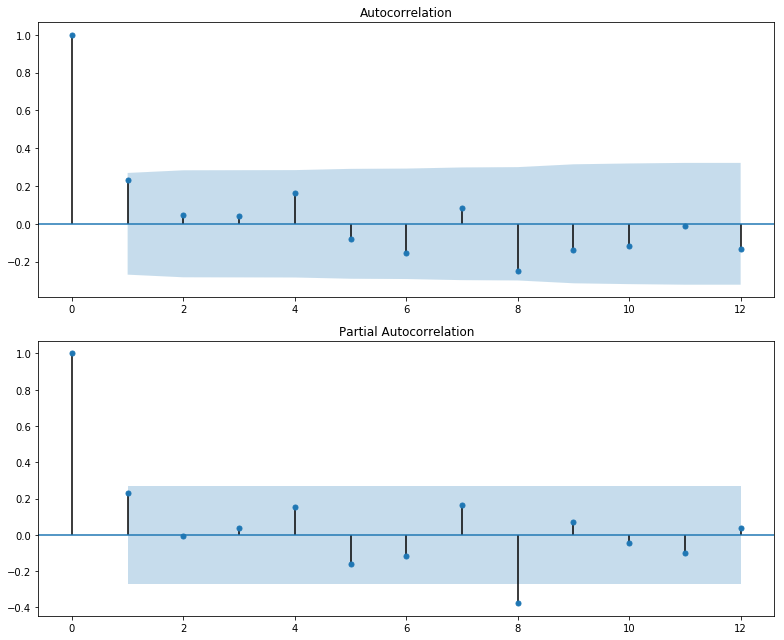

In [29]:
ax = plt.subplot(211)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

This 12 months second order ACF and PACF plots suggest that this trend may be captured by an autoregression time series model AR(8)

In [30]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot 

In [31]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(btc_month.box_diff2[13:].values):
    X_train, X_test = btc_month.box_diff2[13:].values[train_index], btc_month.box_diff2[13:].values[test_index]
    ar = AR(X_train)
    model_ar = ar.fit(maxlag=8)
    pred = model_ar.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, dynamic=False)
    error = mean_squared_error(X_test, pred)
    print('Test MSE: %.3f' % error)

Test MSE: 78.693
Test MSE: 91.180
Test MSE: 145.071
Test MSE: 4952.472
Test MSE: 189869.545


AR model is too simple that cannot capture a complex trend like this. Let's try ARIMA model next:

## ARIMA

In [32]:
from itertools import product
import warnings

In [33]:
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.box_cox, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

bad parameter combination: (0, 0)


In [34]:
best_aic

629.6092026073417

In [35]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
0     (0, 1)  629.609203
2     (1, 0)  629.955524
5     (2, 0)  631.455697
1     (0, 2)  631.601614
3     (1, 1)  631.604615


In [36]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


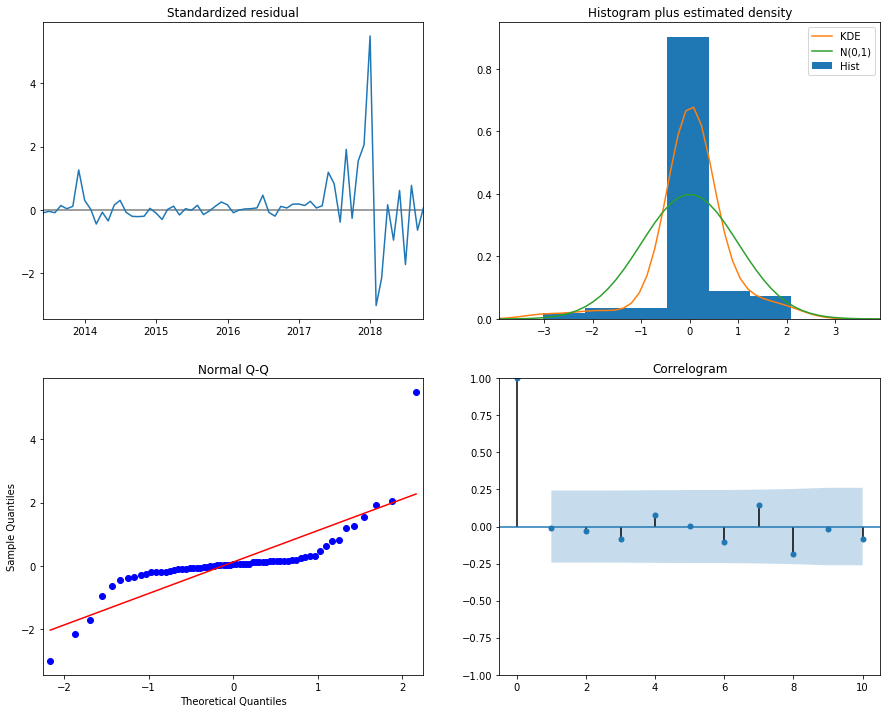

In [37]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [38]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [39]:
btc_month.tail()

,Open,High,Low,Close,Volume,Market Cap,box_cox,box_diff_seasonal_12,box_diff_seasonal_6,box_diff_seasonal_3,box_diff_seasonal_1,box_diff2
Date,,,,,,,,,,,,
2018-05-31,8505.240645,8638.820000,8283.560645,8450.997742,6.374571e+09,1.448831e+11,376.797157,224.079053,17.405610,-26.803232,11.327633,-25.293433
2018-06-30,6829.258000,6930.069000,6670.762667,6793.507667,4.340473e+09,1.167378e+11,330.337509,143.840833,-208.231245,-62.085164,-46.459649,-80.238220
2018-07-31,7101.466452,7258.952581,6982.127419,7146.350000,4.562643e+09,1.218138e+11,340.577283,159.125403,-149.732157,-24.892241,10.239775,15.284570
2018-08-31,6723.800968,6849.496129,6580.563548,6700.130000,4.267509e+09,1.157262e+11,327.592273,91.967869,-76.008116,-49.204884,-12.985010,-67.157534
2018-09-30,6620.669630,6711.180000,6516.843704,6609.207407,4.309814e+09,1.143120e+11,324.904473,82.599870,-67.518200,-5.433036,-2.687800,-9.367998


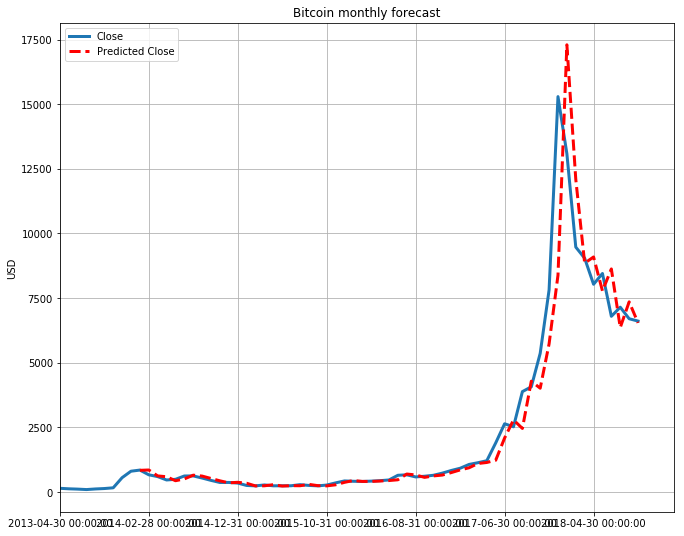

In [40]:
btc_month_pred = btc_month[['Close']]
date_list = [datetime.date(2018, 6, 30), datetime.date(2018, 7, 31), datetime.date(2018, 8, 31), datetime.date(2018, 9, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

btc_month_pred['forecast'] = invboxcox(best_model.predict(start='2014-1-31', end='2018-9-30'), lmbda)

btc_month_pred.Close.plot(linewidth=3)
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

### RNN

In [55]:
#split train test dataset
split_value = int(len(df_btc.Close)*.2)
df_train= df_btc.Close.values[:len(df_btc.Close)-split_value]
df_test= df_btc.Close.values[len(df_btc.Close)-split_value:]

In [127]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(df_train.reshape(-1, 1))
test_set = sc.transform(df_test.reshape(-1,1))
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_test = test_set[0:len(test_set)-1]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 

In [139]:
y_test = df_test[1:len(test_set)]

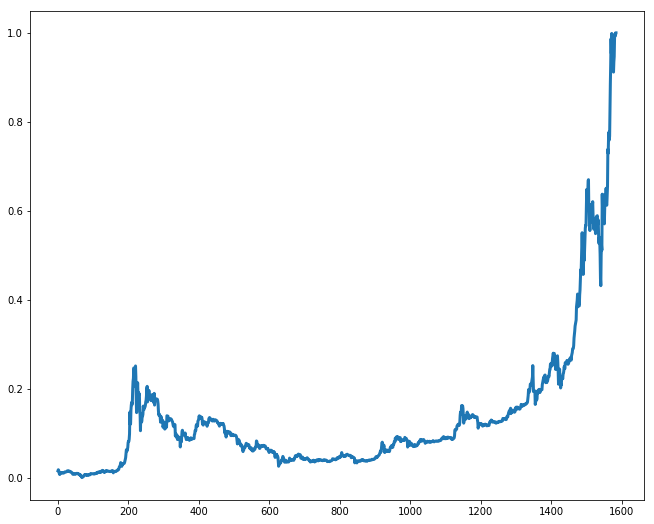

In [103]:
import matplotlib.pyplot as plt
plt.plot(training_set, linewidth=3)
plt.show()

In [153]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
learning_rate = 0.001
num_epoch = 100
batch_size = 32
# callbacks = [EarlyStopping(monitor='val_loss', patience=2),
#              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

regressor = Sequential()
regressor.add(LSTM(units = 20, activation = 'sigmoid', input_shape = (None, 1)))
regressor.add(Dense(units = 1))
# adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
history = regressor.fit(X_train, y_train, batch_size = batch_size, epochs = num_epoch)
loss_history = history.history["loss"]

In [163]:
#tune value
learning_rate = 0.001
num_epoch = 500
batch_size = 128
# callbacks = [EarlyStopping(monitor='val_loss', patience=2),
#              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

regressor = Sequential()
regressor.add(LSTM(units = 20, activation = 'sigmoid', input_shape = (None, 1)))
regressor.add(Dense(units = 1))
# adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
history = regressor.fit(X_train, y_train, batch_size = batch_size, epochs = num_epoch)
loss_history = history.history["loss"]

Epoch 1/500
1583/1583 [==============================] - 3s 2ms/step - loss: 0.1932 - acc: 0.0000e+00
Epoch 2/500
1583/1583 [==============================] - 0s 27us/step - loss: 0.1260 - acc: 6.3171e-04
Epoch 3/500
1583/1583 [==============================] - 0s 29us/step - loss: 0.0800 - acc: 6.3171e-04
Epoch 4/500
1583/1583 [==============================] - 0s 29us/step - loss: 0.0522 - acc: 6.3171e-04
Epoch 5/500
1583/1583 [==============================] - 0s 31us/step - loss: 0.0375 - acc: 6.3171e-04
Epoch 6/500
1583/1583 [==============================] - 0s 31us/step - loss: 0.0306 - acc: 6.3171e-04
Epoch 7/500
1583/1583 [==============================] - 0s 34us/step - loss: 0.0277 - acc: 6.3171e-04
Epoch 8/500
1583/1583 [==============================] - 0s 32us/step - loss: 0.0263 - acc: 6.3171e-04
Epoch 9/500
1583/1583 [==============================] - 0s 29us/step - loss: 0.0256 - acc: 6.3171e-04
Epoch 10/500
1583/1583 [==============================] - 0s 24us/step - l

1583/1583 [==============================] - 0s 26us/step - loss: 0.0035 - acc: 0.0013
Epoch 80/500
1583/1583 [==============================] - 0s 36us/step - loss: 0.0034 - acc: 0.0013
Epoch 81/500
1583/1583 [==============================] - 0s 38us/step - loss: 0.0032 - acc: 0.0013
Epoch 82/500
1583/1583 [==============================] - 0s 33us/step - loss: 0.0031 - acc: 0.0013
Epoch 83/500
1583/1583 [==============================] - 0s 27us/step - loss: 0.0029 - acc: 0.0013
Epoch 84/500
1583/1583 [==============================] - 0s 29us/step - loss: 0.0028 - acc: 0.0013
Epoch 85/500
1583/1583 [==============================] - 0s 35us/step - loss: 0.0027 - acc: 0.0013
Epoch 86/500
1583/1583 [==============================] - 0s 32us/step - loss: 0.0025 - acc: 0.0013
Epoch 87/500
1583/1583 [==============================] - 0s 33us/step - loss: 0.0024 - acc: 0.0013
Epoch 88/500
1583/1583 [==============================] - 0s 25us/step - loss: 0.0023 - acc: 0.0013
Epoch 89/500


1583/1583 [==============================] - 0s 24us/step - loss: 9.5809e-05 - acc: 0.0013
Epoch 158/500
1583/1583 [==============================] - 0s 25us/step - loss: 9.5280e-05 - acc: 0.0013
Epoch 159/500
1583/1583 [==============================] - 0s 29us/step - loss: 9.4909e-05 - acc: 0.0013
Epoch 160/500
1583/1583 [==============================] - 0s 26us/step - loss: 9.4476e-05 - acc: 0.0013
Epoch 161/500
1583/1583 [==============================] - 0s 25us/step - loss: 9.4195e-05 - acc: 0.0013
Epoch 162/500
1583/1583 [==============================] - 0s 25us/step - loss: 9.3842e-05 - acc: 0.0013
Epoch 163/500
1583/1583 [==============================] - 0s 29us/step - loss: 9.3604e-05 - acc: 0.0013
Epoch 164/500
1583/1583 [==============================] - 0s 26us/step - loss: 9.3367e-05 - acc: 0.0013
Epoch 165/500
1583/1583 [==============================] - 0s 21us/step - loss: 9.3106e-05 - acc: 0.0013
Epoch 166/500
1583/1583 [==============================] - 0s 21us/st

1583/1583 [==============================] - 0s 22us/step - loss: 9.1747e-05 - acc: 0.0013
Epoch 236/500
1583/1583 [==============================] - 0s 22us/step - loss: 9.2045e-05 - acc: 0.0013
Epoch 237/500
1583/1583 [==============================] - 0s 22us/step - loss: 9.2000e-05 - acc: 0.0013
Epoch 238/500
1583/1583 [==============================] - 0s 23us/step - loss: 9.1798e-05 - acc: 0.0013
Epoch 239/500
1583/1583 [==============================] - 0s 22us/step - loss: 9.1766e-05 - acc: 0.0013
Epoch 240/500
1583/1583 [==============================] - 0s 22us/step - loss: 9.1959e-05 - acc: 0.0013
Epoch 241/500
1583/1583 [==============================] - 0s 22us/step - loss: 9.1861e-05 - acc: 0.0013
Epoch 242/500
1583/1583 [==============================] - 0s 22us/step - loss: 9.1811e-05 - acc: 0.0013
Epoch 243/500
1583/1583 [==============================] - 0s 21us/step - loss: 9.1783e-05 - acc: 0.0013
Epoch 244/500
1583/1583 [==============================] - 0s 21us/st

1583/1583 [==============================] - 0s 25us/step - loss: 9.2853e-05 - acc: 0.0013
Epoch 314/500
1583/1583 [==============================] - 0s 28us/step - loss: 9.2268e-05 - acc: 0.0013
Epoch 315/500
1583/1583 [==============================] - 0s 27us/step - loss: 9.2218e-05 - acc: 0.0013
Epoch 316/500
1583/1583 [==============================] - 0s 23us/step - loss: 9.1998e-05 - acc: 0.0013
Epoch 317/500
1583/1583 [==============================] - 0s 23us/step - loss: 9.1973e-05 - acc: 0.0013
Epoch 318/500
1583/1583 [==============================] - 0s 23us/step - loss: 9.1887e-05 - acc: 0.0013
Epoch 319/500
1583/1583 [==============================] - 0s 23us/step - loss: 9.2092e-05 - acc: 0.0013
Epoch 320/500
1583/1583 [==============================] - 0s 23us/step - loss: 9.1736e-05 - acc: 0.0013
Epoch 321/500
1583/1583 [==============================] - 0s 23us/step - loss: 9.2227e-05 - acc: 0.0013
Epoch 322/500
1583/1583 [==============================] - 0s 24us/st

1583/1583 [==============================] - 0s 32us/step - loss: 9.2357e-05 - acc: 0.0013
Epoch 392/500
1583/1583 [==============================] - 0s 36us/step - loss: 9.2580e-05 - acc: 0.0013
Epoch 393/500
1583/1583 [==============================] - 0s 36us/step - loss: 9.2212e-05 - acc: 0.0013
Epoch 394/500
1583/1583 [==============================] - 0s 27us/step - loss: 9.1872e-05 - acc: 0.0013
Epoch 395/500
1583/1583 [==============================] - 0s 23us/step - loss: 9.3992e-05 - acc: 0.0013
Epoch 396/500
1583/1583 [==============================] - 0s 22us/step - loss: 9.2577e-05 - acc: 0.0013
Epoch 397/500
1583/1583 [==============================] - 0s 21us/step - loss: 9.2278e-05 - acc: 0.0013
Epoch 398/500
1583/1583 [==============================] - 0s 22us/step - loss: 9.2100e-05 - acc: 0.0013
Epoch 399/500
1583/1583 [==============================] - 0s 23us/step - loss: 9.2231e-05 - acc: 0.0013
Epoch 400/500
1583/1583 [==============================] - 0s 22us/st

1583/1583 [==============================] - 0s 25us/step - loss: 9.2049e-05 - acc: 0.0013
Epoch 470/500
1583/1583 [==============================] - 0s 25us/step - loss: 9.4138e-05 - acc: 0.0013
Epoch 471/500
1583/1583 [==============================] - 0s 25us/step - loss: 9.1685e-05 - acc: 0.0013
Epoch 472/500
1583/1583 [==============================] - 0s 23us/step - loss: 9.2250e-05 - acc: 0.0013
Epoch 473/500
1583/1583 [==============================] - 0s 25us/step - loss: 9.3105e-05 - acc: 0.0013
Epoch 474/500
1583/1583 [==============================] - 0s 28us/step - loss: 9.2587e-05 - acc: 0.0013
Epoch 475/500
1583/1583 [==============================] - 0s 47us/step - loss: 9.1852e-05 - acc: 0.0013
Epoch 476/500
1583/1583 [==============================] - 0s 46us/step - loss: 9.2185e-05 - acc: 0.0013
Epoch 477/500
1583/1583 [==============================] - 0s 37us/step - loss: 9.2220e-05 - acc: 0.0013
Epoch 478/500
1583/1583 [==============================] - 0s 26us/st

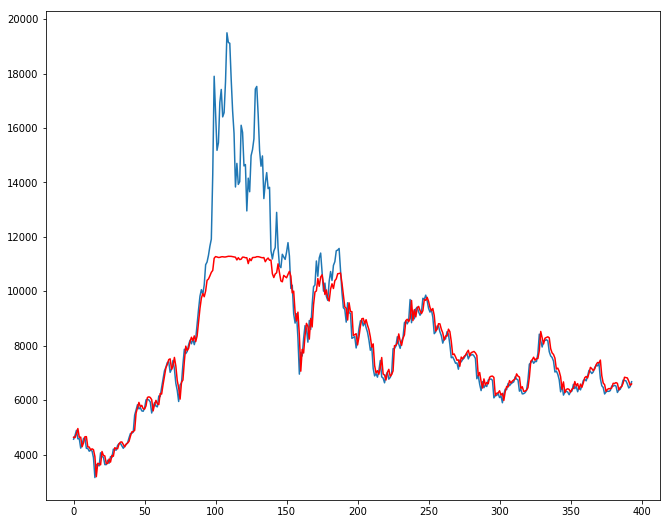

In [164]:
predicted_BTC_price = regressor.predict(X_test)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
plt.plot(y_test)
plt.plot(predicted_BTC_price, 'r')
plt.show()

In [165]:
# rmse
print('The RMSE is: %s'%sqrt(mean_squared_error(y_test, predicted_BTC_price)))

The RMSE is: 1573.674809763587


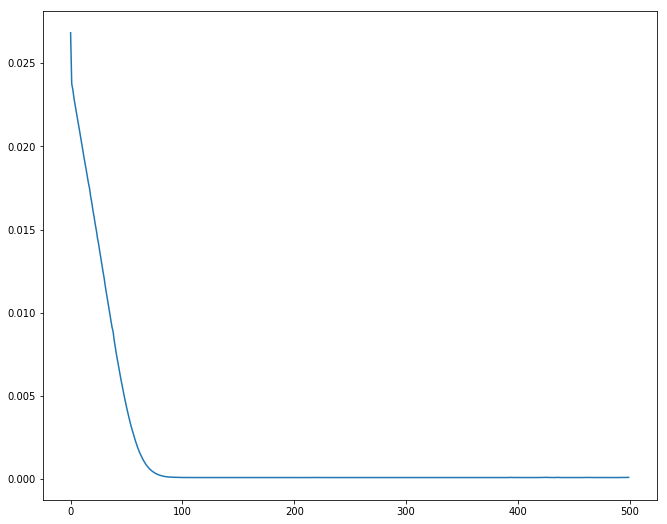

In [137]:
plt.plot(loss_history)
plt.show()

In [138]:
predicted_BTC_price = regressor.predict(X_test)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

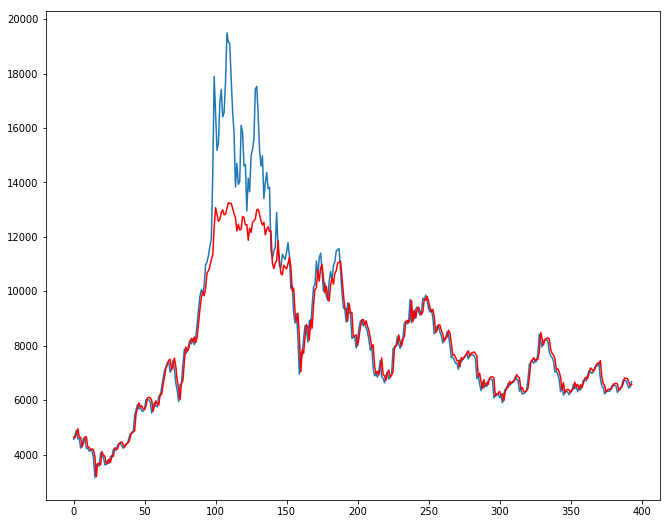

In [140]:
plt.plot(y_test)
plt.plot(predicted_BTC_price, 'r')
plt.show()

In [141]:
# rmse
print('The RMSE is: %s'%sqrt(mean_squared_error(y_test, predicted_BTC_price)))

The RMSE is: 1140.6555220188197
